# Importing the libraries

In [54]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import torch
import math

from tensorflow import keras
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential
from __future__ import print_function
from keras import backend as K
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Flatten, Dense, Activation, MaxPooling2D, Dropout, Input, BatchNormalization, Rescaling
from keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from itertools import product


# Regression CNN

## Loading the 'clocks' data


In [55]:
clock_images = np.load('data/images.npy')
clock_labels = np.load('data/labels.npy')

Creating the dataframe from our np array of labels

In [56]:
labels_df = pd.DataFrame(clock_labels, columns=['hour', 'minute'])
labels_df

,hour,minute
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
17995,11,59
17996,11,59
17997,11,59
17998,11,59


Normalizing the minute value from [0, 1] to create the fractional part of the real time

```
Time --> Real number to represent time
05:30 --> 05.50
```

In [57]:
labels_df['minute_norm'] = labels_df["minute"] / (labels_df["minute"].max()+1)

labels_df['time'] = labels_df['hour'] + labels_df['minute_norm']

In [58]:
labels_df.sample(20)

,hour,minute,minute_norm,time
1469,0,58,0.966667,0.966667
9642,6,25,0.416667,6.416667
2107,1,24,0.400000,1.400000
17031,11,21,0.350000,11.350000
9349,6,13,0.216667,6.216667
4999,3,19,0.316667,3.316667
13370,8,54,0.900000,8.900000
9832,6,33,0.550000,6.550000
7972,5,18,0.300000,5.300000
8220,5,28,0.466667,5.466667


## Regression with normalization

In [59]:
X = clock_images.copy()
y = labels_df.copy()
y.shape

(18000, 4)

## Splitting into test, train and validation sets

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

img_rows, img_cols = X_train[0].shape


# reshape data
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


## Training the CNN with Regression of normalized time

200 epochs were used to train the model but with the usage of a callback method, which would stop the training when the last 5 epochs did not provide an improvement for the metric monitored (val_loss). We also restore the weight from the epoch with the best metric achieved.

In [61]:
np.random.seed(0)
tf.random.set_seed(0)

regression_model = tf.keras.models.Sequential([
      Rescaling(1./255, input_shape=input_shape),
      Conv2D(8, kernel_size=5, strides=1, activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=2), # pool_size=(2, 2), strides=2
      Conv2D(16, kernel_size=3, strides=1, activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=2), # pool_size=(2, 2)
      Conv2D(32, kernel_size=3, strides=1, activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=2), # pool_size=(2, 2)
      Conv2D(64, kernel_size=3, strides=1, activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=2), # pool_size=(2, 2)

      Dropout(.3),
      Flatten(),
      Dense(512, activation='relu'),
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dense(1),      
])

regression_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001), 
    loss=['mae'], 
    metrics=['mse']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = regression_model.fit(X_train, y_train['time'], epochs=
                    200, batch_size = 64,  validation_data=(X_val, y_val['time']), callbacks=[callback])


Epoch 1/200
192/192 [==============================] - 3s 13ms/step - loss: 3.1538 - mse: 13.9390 - val_loss: 3.1081 - val_mse: 13.4472
Epoch 2/200
192/192 [==============================] - 2s 12ms/step - loss: 2.8227 - mse: 11.5869 - val_loss: 2.5889 - val_mse: 10.5682
Epoch 3/200
192/192 [==============================] - 2s 12ms/step - loss: 2.5496 - mse: 10.2597 - val_loss: 2.8762 - val_mse: 13.2715
Epoch 4/200
192/192 [==============================] - 2s 12ms/step - loss: 2.3769 - mse: 9.2601 - val_loss: 2.2504 - val_mse: 8.9260
Epoch 5/200
192/192 [==============================] - 2s 11ms/step - loss: 2.0519 - mse: 7.5649 - val_loss: 1.9697 - val_mse: 7.4446
Epoch 6/200
192/192 [==============================] - 2s 11ms/step - loss: 1.7228 - mse: 5.9380 - val_loss: 1.8297 - val_mse: 6.8193
Epoch 7/200
192/192 [==============================] - 2s 12ms/step - loss: 1.4344 - mse: 4.7373 - val_loss: 1.2361 - val_mse: 3.8981
Epoch 8/200
192/192 [==============================] - 2

In [62]:
# regression_model.save('drive/MyDrive/data/reg_model')
# reg_model = keras.models.load_model('drive/MyDrive/data/reg_model')
# history = reg_model.history
# history['loss']

In [63]:
# Used to generate graphs for loss when training model
'''
fig, axis = plt.subplots(1,1, figsize=(10,6))

axis.plot(history.history['loss'], color='orange', label="Train loss")
axis.plot(history.history['val_loss'], color='blue', label='Validation loss')

axis.set_xlabel('epochs', fontsize=14, fontweight='bold')
axis.set_ylabel('Loss',  fontsize=14, fontweight='bold')
axis.legend(fontsize=12)

fig.tight_layout(pad=3.0)
'''

'\nfig, axis = plt.subplots(1,1, figsize=(10,6))\n\naxis.plot(history.history[\'loss\'], color=\'orange\', label="Train loss")\naxis.plot(history.history[\'val_loss\'], color=\'blue\', label=\'Validation loss\')\n\naxis.set_xlabel(\'epochs\', fontsize=14, fontweight=\'bold\')\naxis.set_ylabel(\'Loss\',  fontsize=14, fontweight=\'bold\')\naxis.legend(fontsize=12)\n\nfig.tight_layout(pad=3.0)\n'

## The "common sense" accuracy/error calculator
Finding the minimum distance of two values of a cyclic feature



In [64]:
def calculate_error(val1, val2, length):
  start_index = 0
  end_index = length-1
  dist_bet = abs(val1 - val2)
  if val1 > val2:
    dist_end = end_index - val1
    dist_start = val2 - start_index
  else: 
    dist_end = end_index - val2
    dist_start = val1 - start_index
  if dist_bet < (dist_end + dist_start + 1):
    return dist_bet
  else:
    return (dist_end + dist_start + 1)

Splittin a list in half and returning the two newly splitted lists

In [65]:
def split_list(a_list):
    half = len(a_list)//2
    return np.array(a_list[:half].T), np.array(a_list[half:].T)

Split a float into integral and fractional part

In [66]:
def split_int_float(x):
  m, h = math.modf(x)
  return [m, h]

Getting prediction and turning them back into minutes and hours from the real number representation of time

In [67]:
predictions = regression_model.predict(X_test)%12
predictions = np.array(predictions)
preds = np.array([split_int_float(x) for x in predictions])
preds_minute , preds_hour = split_list(preds.T)
preds_minute *= 60
preds_minute = np.floor(preds_minute)
preds_hour = np.array(preds_hour, dtype=int)

hour_preds = [item for sublist in preds_hour for item in sublist]
hours_preds_df = pd.DataFrame(hour_preds, columns=['hour'])

minute_preds = [item for sublist in preds_minute for item in sublist]
minutes_preds_df = pd.DataFrame(minute_preds, columns=['minute'])


encoded_hour_preds = pd.get_dummies(hour_preds)
encoded_minute_preds = pd.get_dummies(minute_preds)

Calculating the average accuracy/error of our model by calling the "common sense" accuracy function

In [68]:
all_dists = []
for i in range(len(y_test['minute'])):
  hours = calculate_error(y_test['hour'].iloc[i], hours_preds_df['hour'].iloc[i], 12) * 60
  minutes = calculate_error(y_test['minute'].iloc[i], minutes_preds_df['minute'].iloc[i], 60)
  all_dists.append(hours+minutes)
np.mean(all_dists)

26.10861111111111

______

# Classification


## Loading the 'clocks' data


In [69]:
clock_images = np.load('data/images.npy')
clock_labels = np.load('data/labels.npy')

### Experimenting with visualazing the clocks

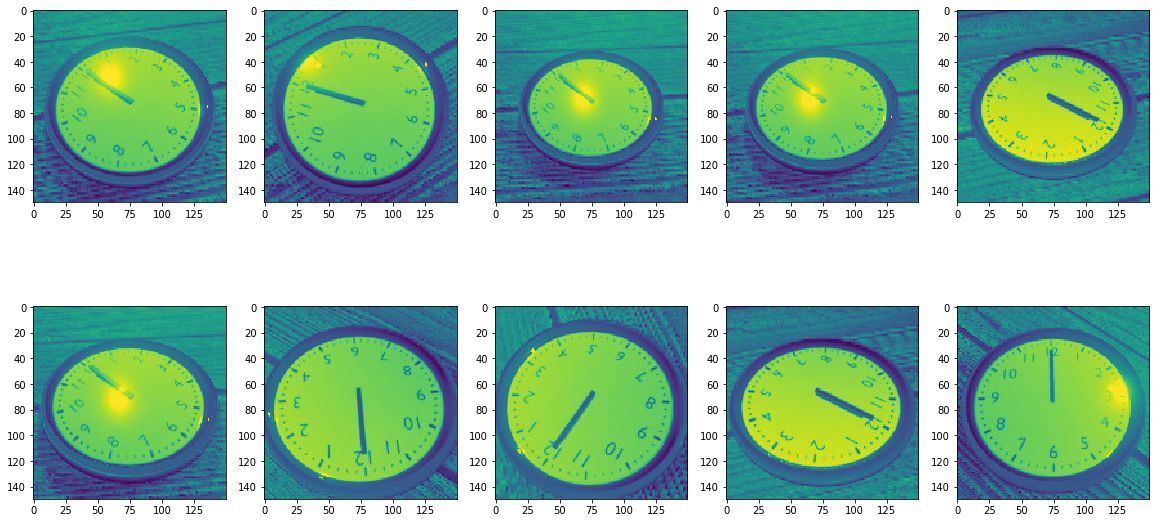

In [70]:
fig, axes = plt.subplots(2, 5, figsize=(20,10))
axes = axes.flatten()

for index, ax in enumerate(axes):
  ax.imshow(clock_images[index], interpolation='none')
  # print(clock_images[i])
plt.show()

Converting the np array of labels to a dataset and also adding an extra column for the minute group (initialized temporarily to zeroes)

In [71]:
labels_df = pd.DataFrame(clock_labels, columns=['hour', 'minute'])
labels_df
labels_df.reset_index()
labels_df.insert(0, 'minute_group', 0)

Method for creating our classes of hour and minute intervals (one-hot encoded)

In [72]:
def create_oh_encoded(labels_df):
  hour_min = [f'{x}_{y}' for x,y in product(labels_df['hour'].unique(), labels_df['minute_group'].unique())]
  data = labels_df.hour.astype("str") + '_'+ labels_df.minute_group.astype("str")
  h_m = pd.crosstab(labels_df.index, data).reindex(hour_min, fill_value=0, axis=1)
  
  return h_m

Filling the minute group column and concatenating the one-hot encoded classes to our dataframe

In [73]:
interval = 10

X = clock_images.copy()
labels_df.minute_group = np.floor(labels_df['minute'] / interval)
y = create_oh_encoded(labels_df).copy()
outputs = len(y.columns)
y = pd.concat((labels_df, y), axis=1)

## Splitting into test, train and validation sets

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

img_rows, img_cols = X_train[0].shape

# reshape data
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

y_val

,minute_group,hour,minute,0_0.0,0_1.0,0_2.0,0_3.0,0_4.0,0_5.0,1_0.0,...,10_2.0,10_3.0,10_4.0,10_5.0,11_0.0,11_1.0,11_2.0,11_3.0,11_4.0,11_5.0
1112,4.0,0,44,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17303,3.0,11,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6460,1.0,4,18,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15351,1.0,10,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10031,4.0,6,41,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13481,5.0,8,59,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10334,5.0,6,53,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16060,4.0,10,42,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7678,0.0,5,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Training the CNN with classification

200 epochs were used to train the model but with the usage of a callback method, which would stop the training when the last 5 epochs did not provide an improvement for the metric monitored (val_loss). We also restore the weight from the epoch with the best metric achieved.

In [75]:
model = tf.keras.models.Sequential([
      # Rescaling(1./255, input_shape=input_shape),
      Conv2D(16, kernel_size=7, strides=1, activation='relu', input_shape=input_shape),  # , input_shape=input_shape
      MaxPooling2D(pool_size=(2, 2), strides=2),
      # Dropout(.2),
      Conv2D(32, kernel_size=5, strides=1, activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=2), 
      Conv2D(64, kernel_size=3, strides=1, activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=2), 
      Conv2D(128, kernel_size=3, strides=1, activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=2), 
      Conv2D(256, kernel_size=3, strides=1, activation='relu'),
      # MaxPooling2D(pool_size=(2, 2), strides=2), 

      Dropout(.3),
      Flatten(),

      Dense(256, activation='relu'),
      # Dropout(.3),
      Dense(outputs*2, activation='relu'),
      Dense(outputs, activation='softmax')    
])

model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001),
    loss= 'categorical_crossentropy',   #tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


history = model.fit(X_train, y_train.iloc[:, 3:], epochs=
                    200, batch_size = 64,  validation_data=(X_val, y_val.iloc[:, 3:]), callbacks=[callback])

Epoch 1/200
169/169 [==============================] - 4s 21ms/step - loss: 4.3939 - accuracy: 0.0156 - val_loss: 4.2512 - val_accuracy: 0.0236
Epoch 2/200
169/169 [==============================] - 4s 21ms/step - loss: 4.1991 - accuracy: 0.0251 - val_loss: 4.0800 - val_accuracy: 0.0361
Epoch 3/200
169/169 [==============================] - 3s 20ms/step - loss: 3.6666 - accuracy: 0.0762 - val_loss: 3.6131 - val_accuracy: 0.0753
Epoch 4/200
169/169 [==============================] - 4s 21ms/step - loss: 2.8599 - accuracy: 0.1698 - val_loss: 2.5418 - val_accuracy: 0.2203
Epoch 5/200
169/169 [==============================] - 3s 20ms/step - loss: 2.2136 - accuracy: 0.3041 - val_loss: 1.9027 - val_accuracy: 0.3808
Epoch 6/200
169/169 [==============================] - 3s 20ms/step - loss: 1.6679 - accuracy: 0.4474 - val_loss: 1.5290 - val_accuracy: 0.4850
Epoch 7/200
169/169 [==============================] - 3s 20ms/step - loss: 1.2759 - accuracy: 0.5601 - val_loss: 1.2300 - val_accuracy:

In [76]:
# model.save('drive/MyDrive/data/classification')
# model = keras.models.load_model('drive/MyDrive/data/classification')

In [77]:
# Used to generate graphs for loss when training model
'''
fig, axis = plt.subplots(1,1, figsize=(10,6))

axis.plot(history.history['loss'], color='orange', label="Train loss")
axis.plot(history.history['val_loss'], color='blue', label='Validation loss')

axis.set_xlabel('epochs', fontsize=14, fontweight='bold')
axis.set_ylabel('Loss',  fontsize=14, fontweight='bold')
axis.legend(fontsize=12)

fig.tight_layout(pad=3.0)
'''

'\nfig, axis = plt.subplots(1,1, figsize=(10,6))\n\naxis.plot(history.history[\'loss\'], color=\'orange\', label="Train loss")\naxis.plot(history.history[\'val_loss\'], color=\'blue\', label=\'Validation loss\')\n\naxis.set_xlabel(\'epochs\', fontsize=14, fontweight=\'bold\')\naxis.set_ylabel(\'Loss\',  fontsize=14, fontweight=\'bold\')\naxis.legend(fontsize=12)\n\nfig.tight_layout(pad=3.0)\n'

## The "common sense" accuracy/error calculator
Finding the minimum distance of two values of a cyclic feature

In [78]:
def calculate_error(val1, val2, length):
  start_index = 0
  end_index = length-1
  dist_bet = abs(val1 - val2)
  if val1 > val2:
    dist_end = end_index - val1
    dist_start = val2 - start_index
  else: 
    dist_end = end_index - val2
    dist_start = val1 - start_index
  if dist_bet < (dist_end + dist_start + 1):
    return dist_bet
  else:
    return (dist_end + dist_start + 1)

Finding the most activated time prediction and converting back to hour and minute groups to calculate our "common sense" accuracy.

In [79]:
predictions = model.predict(X_test)
time_preds = np.argmax(predictions, axis=1)
# print(time_preds)
column_names = y_test.iloc[:, 3:].columns[time_preds]
all_dists = []
for index, c_name in enumerate(column_names):
  hour, minute = c_name.split('_')
  hour = int(hour)
  minute_group = int(float(minute))
  hours = calculate_error(y_test['hour'].iloc[index], hour, 12) * 60
  minutes = calculate_error(y_test['minute_group'].iloc[index], minute_group, interval)*interval
  all_dists.append(hours+minutes)
np.mean(all_dists)

14.136111111111111

____

# Cyclic Encoding

In [80]:
clock_images = np.load('data/images.npy')
clock_labels = np.load('data/labels.npy')

### Experimenting with visualizing the clock images

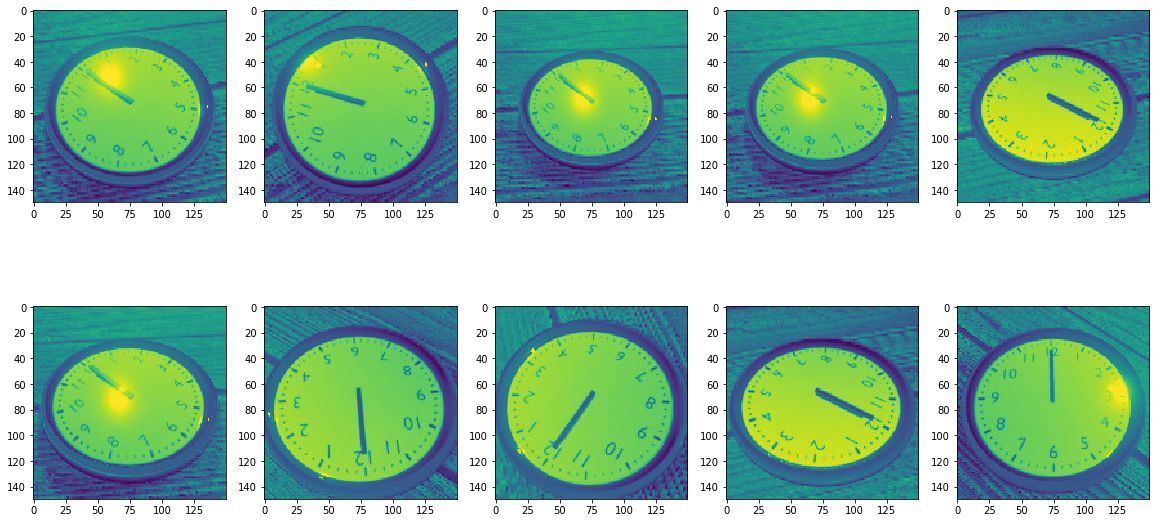

In [81]:
fig, axes = plt.subplots(2, 5, figsize=(20,10))
axes = axes.flatten()

for index, ax in enumerate(axes):
  ax.imshow(clock_images[index], interpolation='none')
  # print(clock_images[i])
plt.show()

## Cyclic encoding 12h format of time

This section is used for pure experimentation with cyclic encoding and visualization of converted data.

Cyclic encoding is used in order to convert time to a cyclic feature, where for example 11:55 to 00:05 will only be a 10 minute difference and not 11 hours and 55 minutes. 

In [82]:
# Create seconds dataframe
def time_in_seconds(labels):
    seconds = list()
    for i in labels:
      seconds.append(np.prod(i))
    return pd.DataFrame(data=dict(seconds=seconds))

In [83]:
labels_seconds = time_in_seconds(clock_labels)
labels_seconds

,seconds
0,0
1,0
2,0
3,0
4,0
...,...
17995,649
17996,649
17997,649
17998,649


In [84]:
seconds_df = labels_seconds.sort_values('seconds').reset_index(drop=True)
# df.head(18000)

In [85]:
minutes_in_12h = 11*59 # analog clocks show 12h format

seconds_df['sin_time'] = np.sin(2*np.pi*seconds_df.seconds/minutes_in_12h)
seconds_df['cos_time'] = np.cos(2*np.pi*seconds_df.seconds/minutes_in_12h)

# normalizing the time in seconds to [0, 1]
seconds_df["seconds_norm"] = 2 * np.pi * seconds_df["seconds"] / seconds_df["seconds"].max()

# dropping the seconds columns
seconds_df.drop('seconds', axis=1, inplace=True)


# df.head()

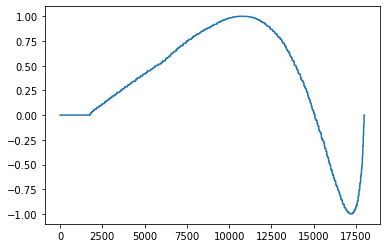

In [86]:
seconds_df.sin_time.plot();


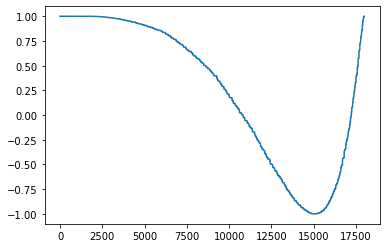

In [87]:
seconds_df.cos_time.plot();


In [88]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=seconds_df.seconds_norm, y=seconds_df.cos_time, name='cos_x'))
fig.add_trace(go.Scatter(x=seconds_df.seconds_norm, y=seconds_df.sin_time, name='sin_x'))

fig.update_layout(yaxis = dict(scaleanchor = "x", scaleratio = 1))

fig.show()

In [89]:
# df.sample(50).plot.scatter('sin_time','cos_time') #.set_aspect('equal')
fig = go.Figure()

# We use [::24] to extract only 60 rows from the 1440
fig.add_trace(go.Scatter(x=seconds_df.cos_time[::24], y=seconds_df.sin_time[::24], mode="markers"))

fig.update_layout(xaxis = dict(title="cos_x"),
                  yaxis = dict(title="sin_x", scaleanchor = "x", scaleratio = 1))

fig.show()

## Cyclic Encoding for hour and minute

In [90]:
clock_images = np.load('data/images.npy')
clock_labels = np.load('data/labels.npy')

Creating the dataframe from the loaded np array of our labels

In [91]:
labels_df = pd.DataFrame(clock_labels, columns=['hour', 'minute'])
labels_df

,hour,minute
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
17995,11,59
17996,11,59
17997,11,59
17998,11,59


Performing cyclic encoding on both minutes and hours separately

In [92]:
labels_df['sin_minute'] = np.sin(2*np.pi*labels_df.minute/59)
labels_df['cos_minute'] = np.cos(2*np.pi*labels_df.minute/59)

labels_df['sin_hour'] = np.sin(2*np.pi*labels_df.hour/11)
labels_df['cos_hour'] = np.cos(2*np.pi*labels_df.hour/11)

In [93]:
X = clock_images.copy()
y = labels_df.copy()
y.shape

(18000, 6)

## Splitting into test, train and validation sets

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

img_rows, img_cols = X_train[0].shape


# reshape data
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


## Training the CNN with cyclic encoding

This CNN will output 4 values:
- sine and cosine for hour
- sine and cosine for minute


200 epochs were used to train the model but with the usage of a callback method, which would stop the training when the last 5 epochs did not provide an improvement for the metric monitored (val_loss). We also restore the weight from the epoch with the best metric achieved.


In [95]:
tf.random.set_seed(0)

model = tf.keras.models.Sequential([
      Rescaling(1./255, input_shape=input_shape),
      Conv2D(8, kernel_size=5, strides=1, padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=2),
      Dropout(.15),

      Conv2D(16, kernel_size=5, strides=1, padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=2), 
      Conv2D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2), strides=2),
      Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'),


      Dropout(.1),
      Flatten(),
      Dense(1024, activation='relu'),
      Dense(128, activation='relu'),
      Dense(128, activation='relu'),
      Dense(4),    
])

model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.001), 
    loss=['mae'], 
    metrics=['mse']
)


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(X_train, y_train[['sin_hour', 'cos_hour', 'sin_minute', 'cos_minute']], epochs=
                    200, batch_size = 64,  validation_data=(X_val, y_val[['sin_hour', 'cos_hour', 'sin_minute', 'cos_minute']]), callbacks=[callback]) 

Epoch 1/200
192/192 [==============================] - 4s 18ms/step - loss: 0.5807 - mse: 0.4506 - val_loss: 0.4925 - val_mse: 0.3564
Epoch 2/200
192/192 [==============================] - 3s 17ms/step - loss: 0.4480 - mse: 0.3096 - val_loss: 0.4212 - val_mse: 0.2795
Epoch 3/200
192/192 [==============================] - 3s 17ms/step - loss: 0.3609 - mse: 0.2202 - val_loss: 0.3111 - val_mse: 0.1676
Epoch 4/200
192/192 [==============================] - 3s 17ms/step - loss: 0.2467 - mse: 0.1142 - val_loss: 0.2140 - val_mse: 0.0885
Epoch 5/200
192/192 [==============================] - 3s 17ms/step - loss: 0.1742 - mse: 0.0578 - val_loss: 0.1729 - val_mse: 0.0585
Epoch 6/200
192/192 [==============================] - 3s 17ms/step - loss: 0.1398 - mse: 0.0361 - val_loss: 0.1429 - val_mse: 0.0401
Epoch 7/200
192/192 [==============================] - 3s 17ms/step - loss: 0.1187 - mse: 0.0257 - val_loss: 0.1207 - val_mse: 0.0288
Epoch 8/200
192/192 [==============================] - 3s 17ms

In [96]:
# model.save('drive/MyDrive/data/cyclic_final')
# model = keras.models.load_model('drive/MyDrive/data/cyclic_final')

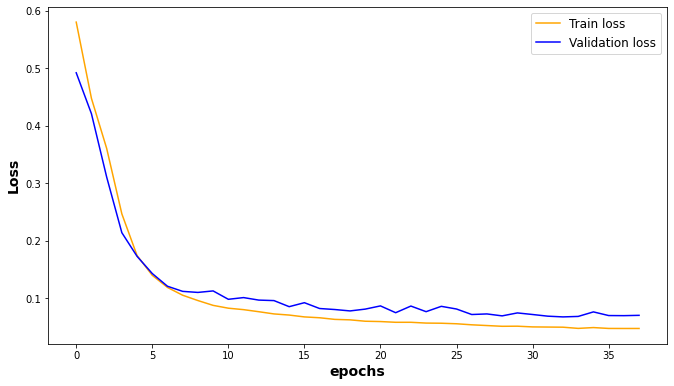

In [97]:
# Used to generate graphs for loss when training model
# '''
fig, axis = plt.subplots(1,1, figsize=(10,6))

axis.plot(history.history['loss'], color='orange', label="Train loss")
axis.plot(history.history['val_loss'], color='blue', label='Validation loss')

axis.set_xlabel('epochs', fontsize=14, fontweight='bold')
axis.set_ylabel('Loss',  fontsize=14, fontweight='bold')
axis.legend(fontsize=12)

fig.tight_layout(pad=3.0)
# '''

## The "common sense" accuracy/error calculator
Finding the minimum distance of two values of a cyclic feature

In [98]:
def calculate_error(val1, val2, length):
  start_index = 0
  end_index = length-1
  dist_bet = abs(val1 - val2)
  if val1 > val2:
    dist_end = end_index - val1
    dist_start = val2 - start_index
  else: 
    dist_end = end_index - val2
    dist_start = val1 - start_index
  if dist_bet < (dist_end + dist_start + 1):
    return dist_bet
  else:
    return (dist_end + dist_start + 1)

Splittin a list in half and returning the two newly splitted lists

In [99]:
def split_list(a_list):
    half = len(a_list)//2
    return np.array(a_list[:half].T), np.array(a_list[half:].T)

Calculating the angle (in degrees) of our sine and cosine values, in order to get the actual hour and minute predictions

In [100]:
def angle_of_both(sn, cs): 
  angles = np.arctan2(sn, cs) 
  angles *= 180 / np.pi
  angles[angles<0] +=360
  return angles

In [101]:
def denormalize(preds, num): # num is either 12 or 60 for hours or minutes
  preds_sin , preds_cos = split_list(preds.T)
  # Fix outliers
  preds_sin[preds_sin < -1] = -1
  preds_sin[preds_sin > 1] = 1
  preds_cos[preds_cos < -1] = -1
  preds_cos[preds_cos > 1] = 1
  # get the angles of each prediction and then change to val
  angles = angle_of_both(preds_sin, preds_cos)
  vals = angles / (360/num)
  return vals


Getting the predictions and converting back to hour and minute values

In [102]:
predictions = model.predict(X_test)
predictions = np.array(predictions)
preds_hour , preds_minute = split_list(predictions.T)
 
hour_preds = np.array(np.floor(denormalize(preds_hour, 12)), dtype=int)
minute_preds = np.array(np.floor(denormalize(preds_minute, 60)), dtype=int)

hours_preds_df = pd.DataFrame(hour_preds, columns=['hour'])
minutes_preds_df = pd.DataFrame(minute_preds, columns=['minute'])

encoded_hour_preds = pd.get_dummies(hours_preds_df['hour'])
encoded_minute_preds = pd.get_dummies(minutes_preds_df['minute'])


encoded_hour_target = pd.get_dummies(y_test['hour'])
encoded_minute_target = pd.get_dummies(y_test['minute'])

Calculating the average accuracy/error of our model by calling the "common sense" accuracy function

In [103]:
all_dists = []
for i in range(len(y_test['minute'])):
  hours = calculate_error(y_test['hour'].iloc[i], hours_preds_df['hour'].iloc[i], 12) * 60
  minutes = calculate_error(y_test['minute'].iloc[i], minutes_preds_df['minute'].iloc[i], 60)
  all_dists.append(hours+minutes)
np.mean(all_dists)

9.795833333333333

_____

# Multi-head with Classification and Cyclic Encoding

## Loading the 'clocks' data


In [104]:
clock_images = np.load('data/images.npy')
clock_labels = np.load('data/labels.npy')

Converting the np array of labels to a dataset


In [105]:
labels_reformed = pd.DataFrame(clock_labels, columns=['hour', 'minute'])
labels_reformed

,hour,minute
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
17995,11,59
17996,11,59
17997,11,59
17998,11,59


## Cyclic encoding on minutes

In [106]:
labels_reformed['sin_minute'] = np.sin(2*np.pi*labels_reformed.minute/59)
labels_reformed['cos_minute'] = np.cos(2*np.pi*labels_reformed.minute/59)

In [107]:
X = clock_images.copy()
y = labels_reformed.copy()
y

,hour,minute,sin_minute,cos_minute
0,0,0,0.000000e+00,1.0
1,0,0,0.000000e+00,1.0
2,0,0,0.000000e+00,1.0
3,0,0,0.000000e+00,1.0
4,0,0,0.000000e+00,1.0
...,...,...,...,...
17995,11,59,-2.449294e-16,1.0
17996,11,59,-2.449294e-16,1.0
17997,11,59,-2.449294e-16,1.0
17998,11,59,-2.449294e-16,1.0


## Splitting into test, train and validation sets

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

img_rows, img_cols = X_train[0].shape

# reshape data
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Training the CNN with two heads

One head is used for the prediction of hours and the other for minutes. Hours uses sparse categorical crossentropy and we cycle encode the minutes. The CNN will provide 2 different prediction, one for each head, an array of 12 columns for the hours, holding respective activation values and sine and cosine values for minutes.

200 epochs were used to train the model but with the usage of a callback method, which would stop the training when the last 5 epochs did not provide an improvement for the metric monitored (val_loss). We also restore the weight from the epoch with the best metric achieved.

In [109]:
np.random.seed(0)
tf.random.set_seed(0)

inp = Input(shape=input_shape)
# x = Rescaling(1./255)(inp)
x = Conv2D(32, kernel_size=5, strides=2, activation='relu')(inp) 
x = MaxPooling2D(pool_size=(2,2), strides=2)(x) 
x = Dropout(.1)(x) # 0.05

x = Conv2D(64, kernel_size=3, strides=1, activation='relu')(x) 
x = MaxPooling2D(pool_size=(2,2), strides=2)(x)   

x = Conv2D(128, kernel_size=3, strides=1, activation='relu')(x) 
x = MaxPooling2D(pool_size=(2,2), strides=2)(x)  
x = Conv2D(256, kernel_size=2, strides=2, activation='relu')(x) 

x = Dropout(.3)(x)

x = Flatten()(x)

hour = Dense(144, activation='relu')(x)
hour = Dense(144, activation='relu')(hour)
hour = Dense(12, activation='softmax', name='hour')(hour)

minute = Dense(512, activation='relu')(x)
minute = Dense(256, activation='relu')(minute)
minute = Dense(2, activation='linear', name='minute')(minute)

metrics = {
    'hour': 'accuracy',
    'minute': 'mae'
}

losses = {
    'hour': 'sparse_categorical_crossentropy',
    'minute': 'mae'
}

train_out = {
    'hour': y_train['hour'],
    'minute': y_train[['sin_minute', 'cos_minute']]
} 

val_out = {
    'hour': y_val['hour'],
    'minute': y_val[['sin_minute', 'cos_minute']]
}
model = Model(inputs=inp, outputs=[hour, minute])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(loss=losses, optimizer='adam', metrics=metrics)
history = model.fit(X_train, train_out , epochs=200, batch_size = 64,  validation_data=(X_val, val_out), callbacks=[callback]) #  validation_data=valid_data

Epoch 1/200
192/192 [==============================] - 4s 14ms/step - loss: 3.8470 - hour_loss: 2.6479 - minute_loss: 1.1990 - hour_accuracy: 0.0793 - minute_mae: 1.1990 - val_loss: 3.1172 - val_hour_loss: 2.4849 - val_minute_loss: 0.6323 - val_hour_accuracy: 0.0815 - val_minute_mae: 0.6323
Epoch 2/200
192/192 [==============================] - 2s 12ms/step - loss: 3.1216 - hour_loss: 2.4866 - minute_loss: 0.6350 - hour_accuracy: 0.0832 - minute_mae: 0.6350 - val_loss: 3.1195 - val_hour_loss: 2.4857 - val_minute_loss: 0.6337 - val_hour_accuracy: 0.0782 - val_minute_mae: 0.6337
Epoch 3/200
192/192 [==============================] - 2s 12ms/step - loss: 3.1208 - hour_loss: 2.4864 - minute_loss: 0.6345 - hour_accuracy: 0.0846 - minute_mae: 0.6345 - val_loss: 3.1206 - val_hour_loss: 2.4871 - val_minute_loss: 0.6335 - val_hour_accuracy: 0.0824 - val_minute_mae: 0.6335
Epoch 4/200
192/192 [==============================] - 2s 12ms/step - loss: 3.1181 - hour_loss: 2.4860 - minute_loss: 0.6321

In [110]:
# model.save('drive/MyDrive/data/multi')
# model = keras.models.load_model('drive/MyDrive/data/multi')

In [111]:
# Used to generate graphs for loss when training model
'''
fig, axis = plt.subplots(1,1, figsize=(10,6))

axis.plot(history.history['loss'], color='orange', label="Train loss")
axis.plot(history.history['val_loss'], color='blue', label='Validation loss')

axis.set_xlabel('epochs', fontsize=14, fontweight='bold')
axis.set_ylabel('Loss',  fontsize=14, fontweight='bold')
axis.legend(fontsize=12)

fig.tight_layout(pad=3.0)
'''

'\nfig, axis = plt.subplots(1,1, figsize=(10,6))\n\naxis.plot(history.history[\'loss\'], color=\'orange\', label="Train loss")\naxis.plot(history.history[\'val_loss\'], color=\'blue\', label=\'Validation loss\')\n\naxis.set_xlabel(\'epochs\', fontsize=14, fontweight=\'bold\')\naxis.set_ylabel(\'Loss\',  fontsize=14, fontweight=\'bold\')\naxis.legend(fontsize=12)\n\nfig.tight_layout(pad=3.0)\n'

## The "common sense" accuracy/error calculator
Finding the minimum distance of two values of a cyclic feature

In [112]:
def calculate_error(val1, val2, length):
  start_index = 0
  end_index = length-1
  dist_bet = abs(val1 - val2)
  if val1 > val2:
    dist_end = end_index - val1
    dist_start = val2 - start_index
  else: 
    dist_end = end_index - val2
    dist_start = val1 - start_index
  if dist_bet < (dist_end + dist_start + 1):
    return dist_bet
  else:
    return (dist_end + dist_start + 1)

Splittin a list in half and returning the two newly splitted lists

In [113]:
def split_list(a_list):
    half = len(a_list)//2
    return np.array(a_list[:half].T), np.array(a_list[half:].T)

Calculating the angle (in degrees) of our sine and cosine values, in order to get the actual hour and minute predictions

In [114]:
def angle_of_both(sn, cs): 
  angles = np.arctan2(sn, cs) 
  angles *= 180 / np.pi
  angles[angles<0] +=360
  return angles

In [115]:
def denormalize(preds, num): # num is either 12 or 60 for hours or minutes
  preds_sin , preds_cos = split_list(preds.T)
  # Fix outliers
  preds_sin[preds_sin < -1] = -1
  preds_sin[preds_sin > 1] = 1
  preds_cos[preds_cos < -1] = -1
  preds_cos[preds_cos > 1] = 1
  # get the angles of each prediction and then change to val
  angles = angle_of_both(preds_sin, preds_cos)
  vals = angles / (360/num)
  return vals


In [116]:
predictions = model.predict(X_test)
preds_hour = predictions[0]
hours_preds = np.argmax(preds_hour, axis=1)
preds_mins = predictions[1]
minute_preds = np.array(np.floor(denormalize(preds_mins, 60)), dtype=int)

minutes_preds_df = pd.DataFrame(minute_preds, columns=['minute'])

Calculating the average accuracy/error of our model by calling the "common sense" accuracy function

In [117]:
all_dists = []
for i in range(len(y_test['minute'])):
  hours = calculate_error(y_test['hour'].iloc[i], hours_preds[i], 12) * 60
  minutes = calculate_error(y_test['minute'].iloc[i], minutes_preds_df['minute'].iloc[i], 60)
  all_dists.append(hours+minutes)
np.mean(all_dists)

7.612222222222222

______

# Multi-head with two cycling encoding heads

## Loading the 'clocks' data


In [118]:
clock_images = np.load('data/images.npy')
clock_labels = np.load('data/labels.npy')

Converting the np array of labels to a dataset


In [119]:
labels_reformed = pd.DataFrame(clock_labels, columns=['hour', 'minute'])
labels_reformed

,hour,minute
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
17995,11,59
17996,11,59
17997,11,59
17998,11,59


## Performing cyclic encoding

In [120]:
labels_reformed['sin_minute'] = np.sin(2*np.pi*labels_reformed.minute/59)
labels_reformed['cos_minute'] = np.cos(2*np.pi*labels_reformed.minute/59)
labels_reformed['sin_hour'] = np.sin(2*np.pi*labels_reformed.hour/11)
labels_reformed['cos_hour'] = np.cos(2*np.pi*labels_reformed.hour/11)

In [121]:
X = clock_images.copy()
y = labels_reformed.copy()
y

,hour,minute,sin_minute,cos_minute,sin_hour,cos_hour
0,0,0,0.000000e+00,1.0,0.000000e+00,1.0
1,0,0,0.000000e+00,1.0,0.000000e+00,1.0
2,0,0,0.000000e+00,1.0,0.000000e+00,1.0
3,0,0,0.000000e+00,1.0,0.000000e+00,1.0
4,0,0,0.000000e+00,1.0,0.000000e+00,1.0
...,...,...,...,...,...,...
17995,11,59,-2.449294e-16,1.0,-1.133108e-15,1.0
17996,11,59,-2.449294e-16,1.0,-1.133108e-15,1.0
17997,11,59,-2.449294e-16,1.0,-1.133108e-15,1.0
17998,11,59,-2.449294e-16,1.0,-1.133108e-15,1.0


## Splitting into test, train and validation sets

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

img_rows, img_cols = X_train[0].shape

# reshape data
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_val = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Training the CNN with two heads

One head is used for the prediction of hours and the other for minutes. Both have been cyclic encoded and the CNN will provide 2 different prediction, one for each head, which consists of two value, the sine and cosine values.

200 epochs were used to train the model but with the usage of a callback method, which would stop the training when the last 5 epochs did not provide an improvement for the metric monitored (val_loss). We also restore the weight from the epoch with the best metric achieved.


In [123]:
inp = Input(shape=input_shape)
x = Rescaling(1./255)(inp)

x = Conv2D(16, kernel_size=7, strides=2, activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=2)(x) 
# x = Dropout(.1)(x) # 0.05

x = Conv2D(32, kernel_size=3, strides=1, activation='relu')(x) 
x = MaxPooling2D(pool_size=(2,2), strides=2)(x)   

x = Conv2D(64, kernel_size=3, strides=1, activation='relu')(x) 
x = MaxPooling2D(pool_size=(2,2), strides=2)(x)  
x = Conv2D(128, kernel_size=3, strides=2, activation='relu')(x) 

x = Dropout(.25)(x)

x = Flatten()(x)
# x = Dropout(.1)(x) # 0.05

# hour = Dense(512, activation='relu')(x)
hour = Dense(512, activation='relu')(x)
hour = Dense(256, activation='relu')(x)
hour = Dense(256, activation='relu')(hour)
hour = Dense(2, activation='linear', name='hour')(hour)

# minute = Dense(512, activation='relu')(x)
minute = Dense(512, activation='relu')(x)
minute = Dense(256, activation='relu')(x)
minute = Dense(256, activation='relu')(minute)
minute = Dense(2, activation='linear', name='minute')(minute)

metrics = {
    'hour': 'mae',
    'minute': 'mae'
}

losses = {
    'hour': 'mae',
    'minute': 'mae'
}

train_out = {
    'hour': y_train[['sin_hour', 'cos_hour']],
    'minute': y_train[['sin_minute', 'cos_minute']]
} 

val_out = {
    'hour': y_val[['sin_hour', 'cos_hour']],
    'minute': y_val[['sin_minute', 'cos_minute']]
}
model = Model(inputs=inp, outputs=[hour, minute])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(loss=losses, optimizer='adam', metrics=metrics)
history = model.fit(X_train, train_out , epochs=200, batch_size = 128,  validation_data=(X_val, val_out), callbacks=[callback])

Epoch 1/200
96/96 [==============================] - 2s 16ms/step - loss: 1.2567 - hour_loss: 0.6231 - minute_loss: 0.6336 - hour_mae: 0.6231 - minute_mae: 0.6336 - val_loss: 1.2192 - val_hour_loss: 0.6121 - val_minute_loss: 0.6070 - val_hour_mae: 0.6121 - val_minute_mae: 0.6070
Epoch 2/200
96/96 [==============================] - 1s 13ms/step - loss: 1.0714 - hour_loss: 0.5293 - minute_loss: 0.5421 - hour_mae: 0.5293 - minute_mae: 0.5421 - val_loss: 0.9277 - val_hour_loss: 0.4583 - val_minute_loss: 0.4694 - val_hour_mae: 0.4583 - val_minute_mae: 0.4694
Epoch 3/200
96/96 [==============================] - 1s 13ms/step - loss: 0.8680 - hour_loss: 0.4249 - minute_loss: 0.4431 - hour_mae: 0.4249 - minute_mae: 0.4431 - val_loss: 0.7910 - val_hour_loss: 0.3887 - val_minute_loss: 0.4023 - val_hour_mae: 0.3887 - val_minute_mae: 0.4023
Epoch 4/200
96/96 [==============================] - 1s 13ms/step - loss: 0.7209 - hour_loss: 0.3533 - minute_loss: 0.3676 - hour_mae: 0.3533 - minute_mae: 0.36

In [124]:
# model.save('drive/MyDrive/data/multi_cyclic')
# model = keras.models.load_model('drive/MyDrive/data/multi_cyclic')

In [125]:
# Used to generate graphs for loss when training model
'''
fig, axis = plt.subplots(1,1, figsize=(10,6))

axis.plot(history.history['loss'], color='orange', label="Train loss")
axis.plot(history.history['val_loss'], color='blue', label='Validation loss')

axis.set_xlabel('epochs', fontsize=14, fontweight='bold')
axis.set_ylabel('Loss',  fontsize=14, fontweight='bold')
axis.legend(fontsize=12)

fig.tight_layout(pad=3.0)
'''

'\nfig, axis = plt.subplots(1,1, figsize=(10,6))\n\naxis.plot(history.history[\'loss\'], color=\'orange\', label="Train loss")\naxis.plot(history.history[\'val_loss\'], color=\'blue\', label=\'Validation loss\')\n\naxis.set_xlabel(\'epochs\', fontsize=14, fontweight=\'bold\')\naxis.set_ylabel(\'Loss\',  fontsize=14, fontweight=\'bold\')\naxis.legend(fontsize=12)\n\nfig.tight_layout(pad=3.0)\n'

## The "common sense" accuracy/error calculator
Finding the minimum distance of two values of a cyclic feature



In [126]:
def calculate_error(val1, val2, length):
  start_index = 0
  end_index = length-1
  dist_bet = abs(val1 - val2)
  if val1 > val2:
    dist_end = end_index - val1
    dist_start = val2 - start_index
  else: 
    dist_end = end_index - val2
    dist_start = val1 - start_index
  if dist_bet < (dist_end + dist_start + 1):
    return dist_bet
  else:
    return (dist_end + dist_start + 1)

Splittin a list in half and returning the two newly splitted lists

In [127]:
def split_list(a_list):
    half = len(a_list)//2
    return np.array(a_list[:half].T), np.array(a_list[half:].T)

Calculating the angle (in degrees) of our sine and cosine values, in order to get the actual hour and minute predictions

In [128]:
def angle_of_both(sn, cs): 
  angles = np.arctan2(sn, cs) 
  angles *= 180 / np.pi
  angles[angles<0] +=360
  return angles

In [129]:
def denormalize(preds, num): # num is either 12 or 60 for hours or minutes
  preds_sin , preds_cos = split_list(preds.T)
  # Fix outliers
  preds_sin[preds_sin < -1] = -1
  preds_sin[preds_sin > 1] = 1
  preds_cos[preds_cos < -1] = -1
  preds_cos[preds_cos > 1] = 1
  # get the angles of each prediction and then change to val
  angles = angle_of_both(preds_sin, preds_cos)
  vals = angles / (360/num)
  return vals


In [130]:
predictions = model.predict(X_test)
preds_hour = predictions[0]
preds_mins = predictions[1]
hour_preds = np.array(np.floor(denormalize(preds_hour, 12)), dtype=int)
minute_preds = np.array(np.floor(denormalize(preds_mins, 60)), dtype=int)

hours_preds_df = pd.DataFrame(hour_preds, columns=['hour'])
minutes_preds_df = pd.DataFrame(minute_preds, columns=['minute'])

Calculating the average accuracy/error of our model by calling the "common sense" accuracy function

In [131]:
all_dists = []
for i in range(len(y_test['minute'])):
  hours = calculate_error(y_test['hour'].iloc[i], hours_preds_df['hour'].iloc[i], 12) * 60
  minutes = calculate_error(y_test['minute'].iloc[i], minutes_preds_df['minute'].iloc[i], 60)
  all_dists.append(hours+minutes)
np.mean(all_dists)

11.7075